In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# import libraries
import numpy as np
import sys
import psi4
np.set_printoptions(threshold=sys.maxsize)
psi4.core.set_output_file('output.dat', False)
import time
import json
import matplotlib.pyplot as plt
import json
import os

# import libraries
import numpy as np
import sys
import psi4
np.set_printoptions(threshold=sys.maxsize)
psi4.core.set_output_file('output.dat', False)
import time
import json
import matplotlib.pyplot as plt
import json
import os 


In [2]:



class PT_arbitrary:

    def __init__(self, energies, dipoles):
        self.E_array = energies
        self.dipoles = dipoles




    def create_annihilation_operator(self,N):
        """
        Creates the matrix representation of the annihilation operator (b) for a harmonic oscillator
        in a Hilbert space with N levels.
        
        Parameters:
        N (int): Number of levels.
        
        Returns:
        np.ndarray: The matrix representation of the annihilation operator.
        """
        b = np.zeros((N, N))
        
        for j in range(1, N):
            b[j-1, j] = np.sqrt(j)
        
        return b

    def create_creation_operator(self,N):
        """
        Creates the matrix representation of the creation operator (b†) for a harmonic oscillator
        in a Hilbert space with N levels.
        
        Parameters:
        N (int): Number of levels.
        
        Returns:
        np.ndarray: The matrix representation of the creation operator.
        """
        b_dagger = np.zeros((N, N))
        
        for j in range(1, N):
            b_dagger[j, j-1] = np.sqrt(j)
        
        return b_dagger



    def create_number_operator(self,N):
        """
        Creates the matrix representation of the number operator (n) = b† * b.
        
        Parameters:
        N (int): Number of levels.
        
        Returns:
        np.ndarray: The matrix representation of the number operator.
        """
        b = self.create_annihilation_operator(N)
        b_dagger = self.create_creation_operator(N)
        
        # The number operator is n = b† * b
        n = np.dot(b_dagger, b)
        
        return n



    def build_d_array(
        self,
        n_el,
        lambda_vector,
        mu_array,
        coherent_state=False,
        coherent_state_pos = None,
        coherent_state_val = None
        ):
        """
        method to compute the array d = \lambda \cdot \mu if coherent_state==False
        or d = \lambda \cdot (\mu - <\mu>) if coherent_state == True
        and store to attribute self.d_array
        """

        if coherent_state == False:
            d_array = np.einsum(
                "k,ijk->ij", lambda_vector, mu_array[:n_el, :n_el, :]
            )

        else:
            _I = np.eye(n_el)
            d_array = np.einsum(
                "k,ijk->ij", lambda_vector, mu_array[:n_el, :n_el, :]
            )

            if coherent_state_val == None and coherent_state_pos == None:
                _d_exp = d_array[0, 0]
            elif coherent_state_val == None and coherent_state_pos != None:
                _d_exp = d_array[coherent_state_pos, coherent_state_pos]
            else:
                _d_exp = coherent_state_val

            d_array = d_array - _I * _d_exp

        return d_array


    def compute_energy_corrections(self, order, n_el, n_ph, omega, lambda_vector,  coherent_state = False, coherent_state_val= None, coherent_state_pos = None, ):

        n_max = n_el * n_ph

        # Identity matrices for each subsystem
        I_matter = np.eye(n_el)
        I_photon = np.eye(n_ph)

        # Build dipole moment matrix _d
        d_array = self.build_d_array(
                n_el, lambda_vector, self.dipoles, coherent_state, coherent_state_pos, coherent_state_val
            )
        _d = np.copy(d_array)


        # Create bosonic subspace operators
        b = self.create_annihilation_operator(n_ph)
        b_dagger = self.create_creation_operator(n_ph)
        N = self.create_number_operator(n_ph)


        # Electronic energy contribution (diagonal in matter space, identity in photon space)
        E_matter = np.diag(self.E_array[:n_el])
        E = np.kron(I_photon, E_matter)

        # Photon energy contribution (diagonal in photon space, identity in matter space)
        Cav_photon = omega * N
        Cav = np.kron( Cav_photon, I_matter)

        #Bilinear light-matter coupling term

        BLC_matter = _d
        BLC_photon = (b_dagger + b)

        BLC = - np.sqrt(omega / 2)  *  np.kron( BLC_photon, I_matter) @ np.kron(I_photon, BLC_matter)


        # Dipole -energy term
        DSE_matter = 1 / 2 * _d @ _d

        DSE = np.kron( I_photon, DSE_matter)

        # Total Hamiltonian
        H0 = E + Cav  
        V= BLC +DSE



        # Diagonalize the unperturbed Hamiltonian
        E0, psi0 = np.linalg.eigh(H0)

        # Initialize corrections to energy and wavefunction
        energy_corrections = np.zeros((n_max, order+1))
        wavefunction_corrections = np.zeros((n_max, n_max, order+1))

        # Set unperturbed energies and wavefunctions
        energy_corrections[:, 0] = E0
        wavefunction_corrections[:, :, 0] = psi0

        # Loop through orders of perturbation theory
        for k in range(1, order+1):
            for n in range(n_max):
                # First-order energy correction
                energy_corrections[n, 1] = np.dot(psi0[:, n].T, np.dot(V, psi0[:, n]))

                # Higher-order corrections
                for m in range(n_max):
                    if m != n:
                        delta_E = E0[n] - E0[m]
                        if delta_E != 0:
                            wavefunction_corrections[m, n, k] = np.dot(psi0[:, m].T, np.dot(V, psi0[:, n])) / delta_E
                            energy_corrections[n, k] = np.sum(np.abs(wavefunction_corrections[:, n, k])**2)

        return energy_corrections#, wavefunction_corrections


    def compute_energy_corrections(self, order, n_el, n_ph, omega, lambda_vector,  coherent_state = False, coherent_state_val= None, coherent_state_pos = None, ):

        n_max = n_el * n_ph
        n = 0

        # Identity matrices for each subsystem
        I_matter = np.eye(n_el)
        I_photon = np.eye(n_ph)

        # Build dipole moment matrix _d
        d_array = self.build_d_array(
                n_el, lambda_vector, self.dipoles, coherent_state, coherent_state_pos, coherent_state_val
            )
        _d = np.copy(d_array)


        # Create bosonic subspace operators
        b = self.create_annihilation_operator(n_ph)
        b_dagger = self.create_creation_operator(n_ph)
        N = self.create_number_operator(n_ph)


        # Electronic energy contribution (diagonal in matter space, identity in photon space)
        E_matter = np.diag(self.E_array[:n_el])
        E = np.kron(I_photon, E_matter)

        # Photon energy contribution (diagonal in photon space, identity in matter space)
        Cav_photon = omega * N
        Cav = np.kron( Cav_photon, I_matter)

        #Bilinear light-matter coupling term

        BLC_matter = _d
        BLC_photon = (b_dagger + b)

        BLC = - np.sqrt(omega / 2)  *  np.kron( BLC_photon, I_matter) @ np.kron(I_photon, BLC_matter)


        # Dipole -energy term
        DSE_matter = 1 / 2 * _d @ _d

        DSE = np.kron( I_photon, DSE_matter)

        # Total Hamiltonian
        H0 = E + Cav  
        V= BLC +DSE



        # Diagonalize the unperturbed Hamiltonian
        E0, psi0 = np.linalg.eigh(H0)


        #psi0[:, 0] is firt wavefunction
        print(psi0.shape)

        # Initialize corrections to energy and wavefunction
        energy_corrections = np.zeros(( order+1))
        wavefunction_corrections = np.zeros((n_max, order+1))



        # Set unperturbed energies and wavefunctions
        energy_corrections[ 0] = E0[n]
        wavefunction_corrections[ :, 0] = psi0[:, n]


        n_0 = 0


        for k in range(1, order + 1):
            
            if k == 1:
                #first order energy correction
                energy_corrections[1] = np.dot(psi0[:, n].T, np.dot(V, psi0[:,n]))

                print(energy_corrections[1])


                coeff_m = 0
                for m in range(0, n_max):
                    coeff_m = 0
                    if m!= n:


                        coeff_m -=   np.dot(psi0[:, m].T, np.dot(V, psi0[:,n]))

                        for l in range(1, k+1):
                            #goes from l to k-1
                            coeff_m += energy_corrections[l] * np.dot(psi0[:, m].T, wavefunction_corrections[:, k-l])

                        coeff_m = coeff_m/np.abs(E0[m] - E0[n])

                        wavefunction_corrections[:, k ] += (coeff_m * psi0[:,m])


            if k!=1:  
                for m in range(0, n_max):
                    coeff_m = 0
                    if m!= n:
                        coeff_m -=  np.dot(psi0[:,m].T, np.dot(V, wavefunction_corrections[:, k-1]))
                        for l in range(1, k+1):
                            #goes from l to k-1
                            coeff_m += energy_corrections[l] * np.dot(psi0[:, m].T, wavefunction_corrections[:, k-l])

                        coeff_m = coeff_m/np.abs(E0[m] - E0[n])
                        # print("coeff_ m for state ", m , ": ", coeff_m)

                        wavefunction_corrections[:, k ] += (coeff_m * psi0[:,m])



            if k!= 1:
                energy_correction =  np.dot(psi0[:,n].T, np.dot(V, wavefunction_corrections[:, k-1]))
                
                for j in range(0, k):
                    if j != k:
                        print("energy correction for ", j ," : " ,energy_correction)
                        energy_correction -=  energy_corrections[j]  * np.dot(psi0[:,n].T,  wavefunction_corrections[:, k-j])

                energy_corrections[ k] = energy_correction


        print("energy_corrections: " , energy_corrections)
        return energy_corrections

                    

 

    def PQED_Hamiltonian(self, n_el, n_ph, omega, lambda_vector,  coherent_state = False, coherent_state_val= None, coherent_state_pos = None,  ):
        """
        Build the PF Hamiltonian for a system with n_el electronic states and n_ph photon states.
        """

        # Identity matrices for each subsystem
        I_matter = np.eye(n_el)
        I_photon = np.eye(n_ph)

        # Build dipole moment matrix _d
        d_array = self.build_d_array(
                n_el, lambda_vector, self.dipoles, coherent_state, coherent_state_pos, coherent_state_val
            )
        _d = np.copy(d_array)


        # Create bosonic subspace operators
        b = self.create_annihilation_operator(n_ph)
        b_dagger = self.create_creation_operator(n_ph)
        N = self.create_number_operator(n_ph)


        # Electronic energy contribution (diagonal in matter space, identity in photon space)
        E_matter = np.diag(self.E_array[:n_el])
        E = np.kron(I_photon, E_matter)

        # Photon energy contribution (diagonal in photon space, identity in matter space)
        Cav_photon = omega * N
        Cav = np.kron( Cav_photon, I_matter)

        #Bilinear light-matter coupling term

        BLC_matter = _d
        BLC_photon = (b_dagger + b)

        BLC = - np.sqrt(omega / 2)  *  np.kron( BLC_photon, I_matter) @ np.kron(I_photon, BLC_matter)


        # Dipole -energy term
        DSE_matter = 1 / 2 * _d @ _d

        DSE = np.kron( I_photon, DSE_matter)

        # Total Hamiltonian
        H = E + Cav  + BLC + DSE


        self.PCQED_MU = np.kron(I_photon, _d)


        # Return eigenvalues of the Hamiltonian
        eigenvalues, eigenvectors = np.linalg.eigh(H)
        return eigenvalues, eigenvectors, H



<>:77: SyntaxWarning: invalid escape sequence '\l'
<>:77: SyntaxWarning: invalid escape sequence '\l'
/var/folders/mb/j1g5yyj51l1_gtt0b347d_gwjf45wq/T/ipykernel_74702/14202325.py:77: SyntaxWarning: invalid escape sequence '\l'
  """


In [3]:
# read data from .npy files for formaldehyde casci(8,8) calculations
#Drive link for .npy files of LiH

# https://drive.google.com/drive/folders/1NQvqQ4KiXTmZZ3OjCM5nA2dqIs5ete9X?usp=sharing

# !!! Change this to the correct path on your computer!
npy_folder = "/Users/proden/Code/POLARITONPERTURBATIONTHEORY/data/"

# these file names should still be good
E_npy_file = npy_folder + "LiH_r_scan_6311g_fci_tight_davidson_Energies.npy"
Mu_npy_file = npy_folder + "LiH_r_scan_6311g_fci_tight_davidson_Dipoles.npy"

# store energy eigenvalues in E_array
E_array = np.load(E_npy_file)
# store dipole matrix elements in Mu_array
Mu_array = np.load(Mu_npy_file)





In [4]:
N_R = 1

d_array = np.linspace(1.4, 2.2, N_R)
N_l = len(d_array)
N_el = 100
N_ph = 3
omega = 0.12086
lambda_vector = np.array([0, 0, 0.05])

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_50010 = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0
for d in d_array:
    instance= PT_arbitrary(E_array[:,ctr], Mu_array[:,:,:,ctr])  # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_50010[ctr, :]  = instance.PQED_Hamiltonian(N_el, N_ph, omega, lambda_vector)[0]

    print(np.sum(instance.compute_energy_corrections(9, N_el, N_ph, omega, lambda_vector)))

    print(_pcqed_50010[ctr, 0])
    ctr += 1

(300, 300)
0.009069161168935956
energy correction for  0  :  -0.00688718906317169
energy correction for  1  :  -0.00688718906317169
energy correction for  0  :  0.0005506349962211957
energy correction for  1  :  0.0005506349962211957
energy correction for  2  :  0.0005506349962211957
energy correction for  0  :  -0.0003018968973511539
energy correction for  1  :  -0.0003018968973511539
energy correction for  2  :  -0.0003018968973511539
energy correction for  3  :  -0.0003018968973511539
energy correction for  0  :  3.9948694267115787e-05
energy correction for  1  :  3.9948694267115787e-05
energy correction for  2  :  3.9948694267115787e-05
energy correction for  3  :  3.9948694267115787e-05
energy correction for  4  :  3.9948694267115787e-05
energy correction for  0  :  4.748434301372064e-06
energy correction for  1  :  4.748434301372064e-06
energy correction for  2  :  4.748434301372064e-06
energy correction for  3  :  4.748434301372064e-06
energy correction for  4  :  4.748434301372

In [5]:


N_R = 1

d_array = np.linspace(1.4, 2.2, N_R)
N_l = len(d_array)
N_el = 100
N_ph = 3
omega = 0.12086
lambda_vector = np.array([0, 0, 0.05])

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_50010 = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0
for d in d_array:
    instance= PT_arbitrary(E_array[:,ctr], Mu_array[:,:,:,ctr])  # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_50010[ctr, :]  = instance.PQED_Hamiltonian(N_el, N_ph, omega, lambda_vector)[0]

    print(np.sum(instance.compute_energy_corrections(9, N_el, N_ph, omega, lambda_vector, coherent_state=True, coherent_state_pos=0)))

    print(_pcqed_50010[ctr, 0])
    ctr += 1

(300, 300)
0.0035636260430959455
energy correction for  0  :  -0.0011944701788421518
energy correction for  1  :  -0.0011944701788421518
energy correction for  0  :  0.00016298226744803918
energy correction for  1  :  0.00016298226744803918
energy correction for  2  :  0.00016298226744803918
energy correction for  0  :  -0.00010630182530747984
energy correction for  1  :  -0.00010630182530747984
energy correction for  2  :  -0.00010630182530747984
energy correction for  3  :  -0.00010630182530747984
energy correction for  0  :  5.2882079974988145e-05
energy correction for  1  :  5.2882079974988145e-05
energy correction for  2  :  5.2882079974988145e-05
energy correction for  3  :  5.2882079974988145e-05
energy correction for  4  :  5.2882079974988145e-05
energy correction for  0  :  -3.38036512591978e-05
energy correction for  1  :  -3.38036512591978e-05
energy correction for  2  :  -3.38036512591978e-05
energy correction for  3  :  -3.38036512591978e-05
energy correction for  4  :  -3

In [6]:


N_R = 1

d_array = np.linspace(1.4, 2.2, N_R)
N_l = len(d_array)
N_el = 200
N_ph = 10
omega = 0.12086
lambda_vector = np.array([0, 0, 0.05])

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_20010 = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0
for d in d_array:
    instance= PT_arbitrary(E_array[:,ctr], Mu_array[:,:,:,ctr])  # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_20010[ctr, :]  = instance.PQED_Hamiltonian(N_el, N_ph, omega, lambda_vector)[0]

    #print(np.sum(instance.compute_energy_corrections(9, N_el, N_ph, omega, lambda_vector, coherent_state=True, coherent_state_pos=0)))

    print(_pcqed_20010[ctr, 0])
    ctr += 1

-8.009664319967834


In [7]:

orders = [0,1,2,3,4,5,6,7,8,9,10]

pt_cs = []
pt_pn = []

N_R = 1

d_array = np.linspace(1.4, 2.2, N_R)
N_l = len(d_array)
N_el = 200
N_ph = 3
omega = 0.12086
lambda_vector = np.array([0, 0, 0.05])

# create an array of zeros to store the PCQED eigenvalues for each value of d
_pcqed_100_3_pn = np.zeros((N_l, N_el * N_ph))
_pcqed_100_3_cs = np.zeros((N_l, N_el * N_ph))
# loop over values of d, build Hamiltonian, capture eigenvalues
ctr = 0

for d in d_array:
    instance= PT_arbitrary(E_array[:,ctr], Mu_array[:,:,:,ctr])  # E_array[:,ctr]: 20 energy values for fisrt displacement and so on... 
    _pcqed_100_3_pn[ctr, :]  = instance.PQED_Hamiltonian(N_el, N_ph, omega, lambda_vector)[0]
    _pcqed_100_3_cs[ctr, :]  = instance.PQED_Hamiltonian(N_el, N_ph, omega, lambda_vector, coherent_state=True,  coherent_state_pos=0)[0]

    for order in orders:
        pt_pn.append(np.sum(instance.compute_energy_corrections(order, N_el, N_ph, omega, lambda_vector)))
        pt_cs.append(np.sum(instance.compute_energy_corrections(order, N_el, N_ph, omega, lambda_vector, coherent_state=True, coherent_state_pos=0)))

    print(_pcqed_50010[ctr, 0])
    ctr += 1

(600, 600)
energy_corrections:  [-8.01219476]
(600, 600)
energy_corrections:  [-8.01219476]
(600, 600)
0.009150854965969662
energy_corrections:  [-8.01219476  0.00915085]
(600, 600)
0.0036453198401296496
energy_corrections:  [-8.01219476e+00  3.64531984e-03]
(600, 600)
0.009150854965969662
energy correction for  0  :  -0.006896513993850218
energy correction for  1  :  -0.006896513993850218
energy_corrections:  [-8.01219476e+00  9.15085497e-03 -6.89651399e-03]
(600, 600)
0.0036453198401296496
energy correction for  0  :  -0.001206796726291617
energy correction for  1  :  -0.001206796726291617
energy_corrections:  [-8.01219476e+00  3.64531984e-03 -1.20679673e-03]
(600, 600)
0.009150854965969662
energy correction for  0  :  -0.006896513993850218
energy correction for  1  :  -0.006896513993850218
energy correction for  0  :  0.0005546483477674363
energy correction for  1  :  0.0005546483477674363
energy correction for  2  :  0.0005546483477674363
energy_corrections:  [-8.01219476e+00  9.15

(-8.0097, -8.0096)

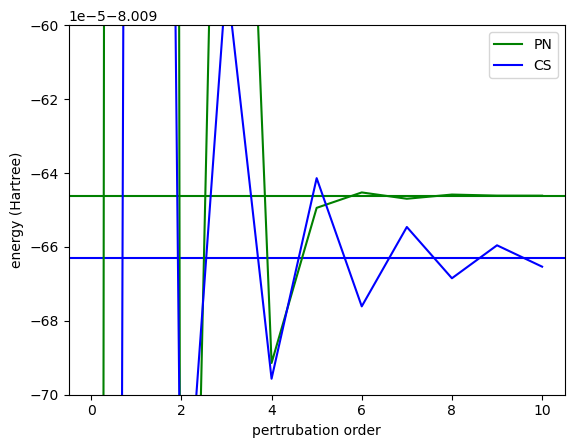

In [11]:
plt.axhline(y = _pcqed_100_3_pn[0, 0], label = "PN" , color = "green")
plt.axhline(y = _pcqed_100_3_cs[0, 0], label = "CS", color = "blue")

plt.plot(pt_pn, color = "green")
plt.plot(pt_cs, color = "blue")

plt.ylabel("energy (Hartree)")
plt.xlabel("pertrubation order")
plt.legend()


plt.ylim(-8.0097, -8.0096)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 0.0001)

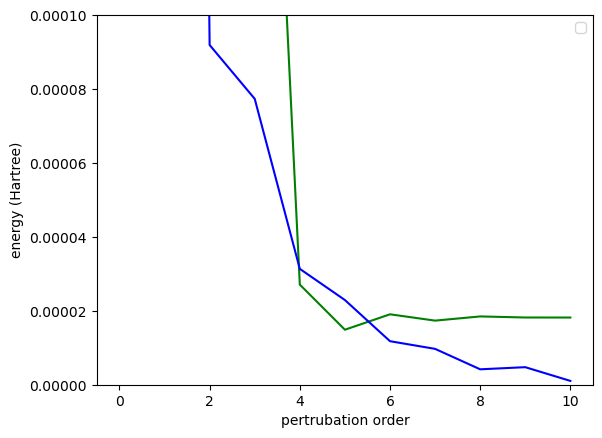

In [12]:

plt.plot(np.abs(pt_pn - _pcqed_20010[0, 0]), color = "green")
plt.plot(np.abs(pt_cs- _pcqed_20010[0, 0]), color = "blue")

plt.ylabel("energy (Hartree)")
plt.xlabel("pertrubation order")
plt.legend()

plt.ylim(0,0.0001)


